In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Logistic Regression-Scratch Implementation.

In [3]:
# Load dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

path_dataset = "/content/drive/MyDrive/week6/titanic.csv"

In [4]:
data = pd.read_csv(path_dataset)

In [5]:
print("Info: ")
data.info()

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
print(data.shape)

(891, 12)


In [7]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


*Constructing One Hot Encoding for Label Vector*:

In [8]:
y = data['Survived'].values
encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

print("One-Hot Encoded Target Vector:")
print(y_onehot)


One-Hot Encoded Target Vector:
[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


Standarize the Input Dataset:

In [9]:
X = data.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'])

X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

y = data['Survived'].values

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

assert X_train_scaled.shape == (X_train.shape[0], X_train.shape[1]), f"X_train_scaled shape mismatch: {X_train_scaled.shape}"
assert X_test_scaled.shape == (X_test.shape[0], X_test.shape[1]), f"X_test_scaled shape mismatch: {X_test_scaled.shape}"

print("Standardization completed successfully!")
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

Standardization completed successfully!
Shape of X_train_scaled: (712, 8)
Shape of X_test_scaled: (179, 8)


### Model Fitting:

Training the Model

In [13]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def compute_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 1e-10)) / y_true.shape[0]

def compute_gradients(X, y_true, y_pred):
    n_samples = X.shape[0]
    grad_W = np.dot(X.T, (y_pred - y_true)) / n_samples
    grad_b = np.sum(y_pred - y_true, axis=0) / n_samples
    return grad_W, grad_b

def gradient_descent(X, y, W, b, alpha, n_iter):
    cost_history = []
    for _ in range(n_iter):
        z = np.dot(X, W) + b
        y_pred = softmax(z)
        cost = compute_loss(y, y_pred)
        cost_history.append(cost)
        grad_W, grad_b = compute_gradients(X, y, y_pred)
        W -= alpha * grad_W
        b -= alpha * grad_b
    return W, b, cost_history

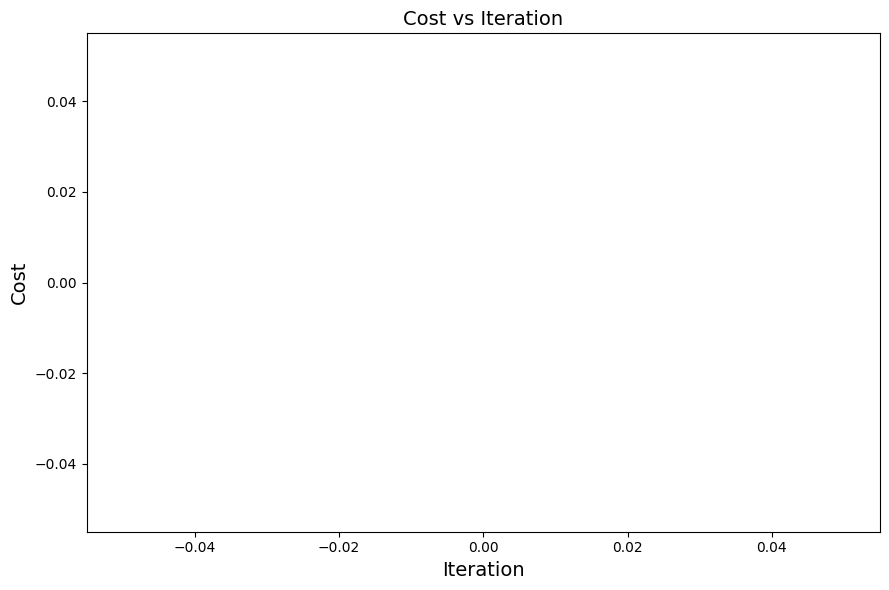

In [15]:
# Set parameters
n_features = X_train_scaled.shape[1]
n_classes = y_train.shape[1]
W = np.zeros((n_features, n_classes))
b = np.zeros(n_classes)
learning_rate = 0.002
n_iterations = 700

# Train the model
W_opt, b_opt, cost_history = gradient_descent(X_train_scaled, y_train, W, b, learning_rate, n_iterations)

# Plotting cost over iteration
plt.figure(figsize = (9, 6))
plt.plot(cost_history)
plt.xlabel("Iteration", fontsize = 14)
plt.ylabel("Cost", fontsize = 14)
plt.title("Cost vs Iteration", fontsize = 14)
plt.tight_layout()
plt.show()

# How well my model did?




In [16]:

def predict(X, W, b):
    z = np.dot(X, W) + b
    y_pred_prob = softmax(z)
    return np.argmax(y_pred_prob, axis=1)

def evaluate_model(X, y_true, W, b):
    y_pred = predict(X, W, b)
    y_true_labels = np.argmax(y_true, axis=1)
    accuracy = np.mean(y_pred == y_true_labels) * 100
    return accuracy, y_pred

test_accuracy, y_test_pred = evaluate_model(X_test_scaled, y_test, W_opt, b_opt)

y_test_true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_true_labels, y_test_pred)

class_report = classification_report(y_test_true_labels, y_test_pred, target_names=["Did Not Survive", "Survived"])

print(f"Test Accuracy: {test_accuracy:.2f}%\n")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Test Accuracy: 61.45%

Confusion Matrix:
[[110   0]
 [ 69   0]]

Classification Report:
                 precision    recall  f1-score   support

Did Not Survive       0.61      1.00      0.76       110
       Survived       0.00      0.00      0.00        69

       accuracy                           0.61       179
      macro avg       0.31      0.50      0.38       179
   weighted avg       0.38      0.61      0.47       179



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
